(https://qiita.com/Ringa_hyj/items/9d92afe3551d86b423f9)

In [4]:
import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   Latitude          161 non-null    float64
 4   Longitude         161 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.4+ KB


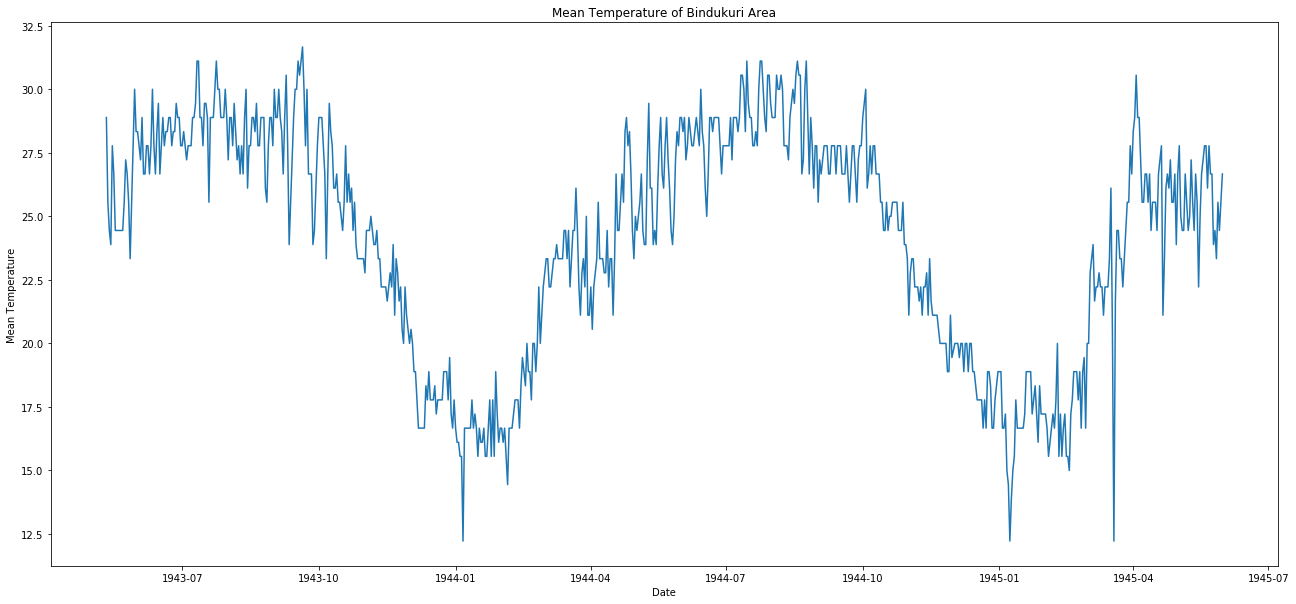

In [5]:
weather_station_location = pd.read_csv('../00.data/Weather Station Locations.csv')
weather = pd.read_csv("../00.data/Summary of Weather.csv")

weather_station_location = weather_station_location.loc[:,["WBAN","NAME","STATE/COUNTRY ID","Latitude","Longitude"] ]
weather_station_location.info()

weather_station_id = weather_station_location[weather_station_location.NAME == "BINDUKURI"].WBAN 
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])

plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

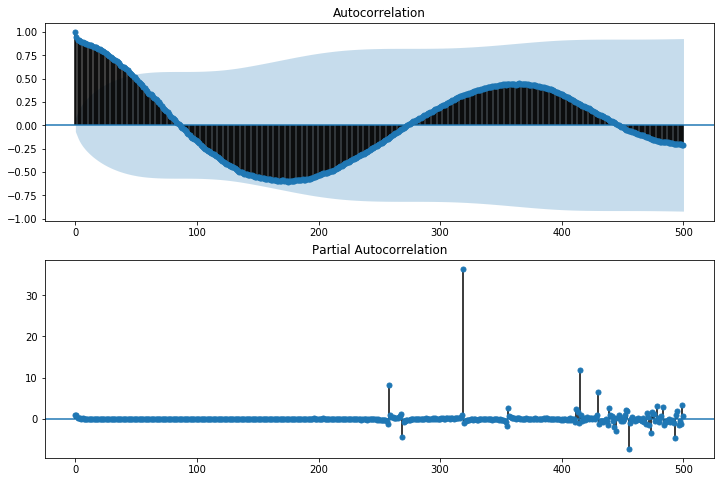

In [6]:
t1=weather_bin.Date
t2=weather_bin.MeanTemp
ts_acf = sm.tsa.stattools.acf(t2, nlags=500)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(t2, lags=500, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(t2, lags=500, ax=ax2)

In [7]:
mod = sm.tsa.statespace.SARIMAX(t2, trend='n', order=(1,0,50), seasonal_order=(0,0,0,12))
results = mod.fit()
print (results.summary())

                               SARIMAX Results                                
Dep. Variable:               MeanTemp   No. Observations:                  751
Model:              SARIMAX(1, 0, 50)   Log Likelihood               -1250.845
Date:                Sat, 11 Apr 2020   AIC                           2605.691
Time:                        20:25:53   BIC                           2846.004
Sample:                             0   HQIC                          2698.283
                                - 751                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.001   1163.196      0.000       0.998       1.001
ma.L1         -0.3505      0.029    -12.090      0.000      -0.407      -0.294
ma.L2         -0.2456      0.036     -6.779      0.0

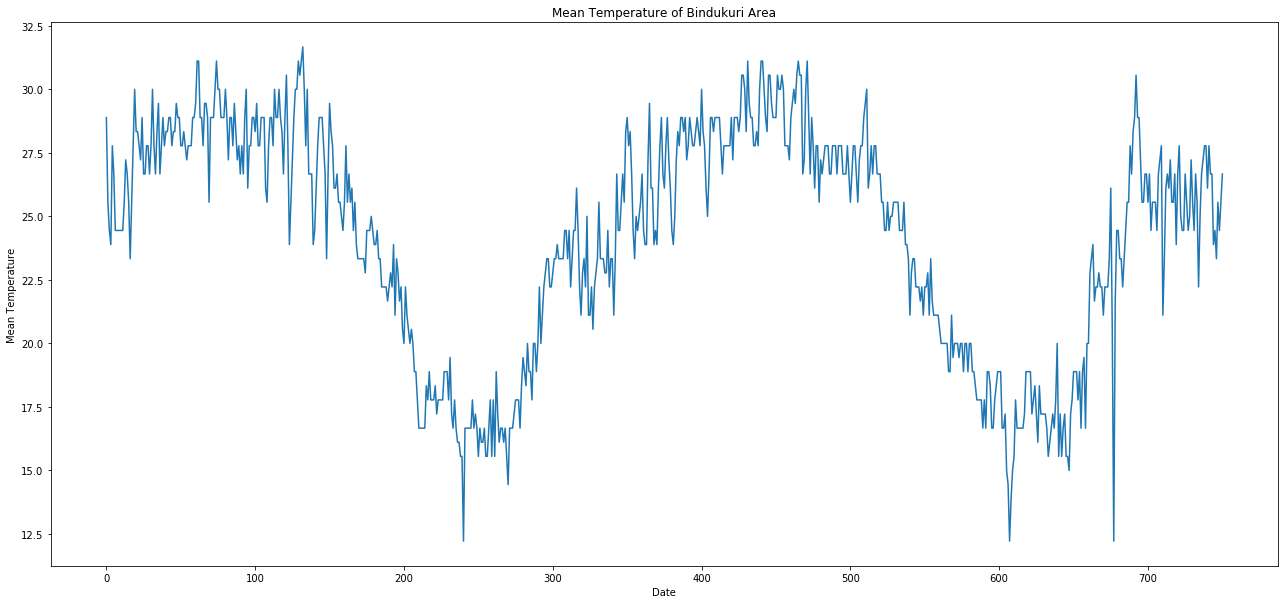

In [8]:
t3=t2.reset_index()
t3=t3.drop('index',axis=1) 
plt.figure(figsize=(22,10))
plt.plot(t3)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

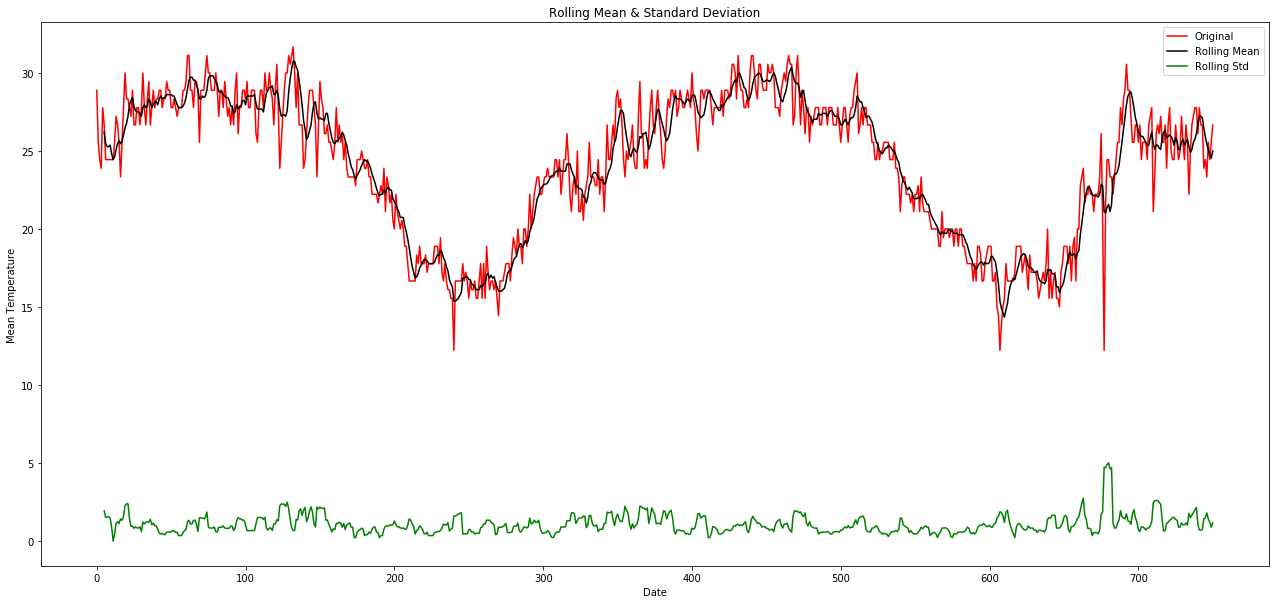

Test statistic:  -1.409596674588767
p-value:  0.5776668028526398
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


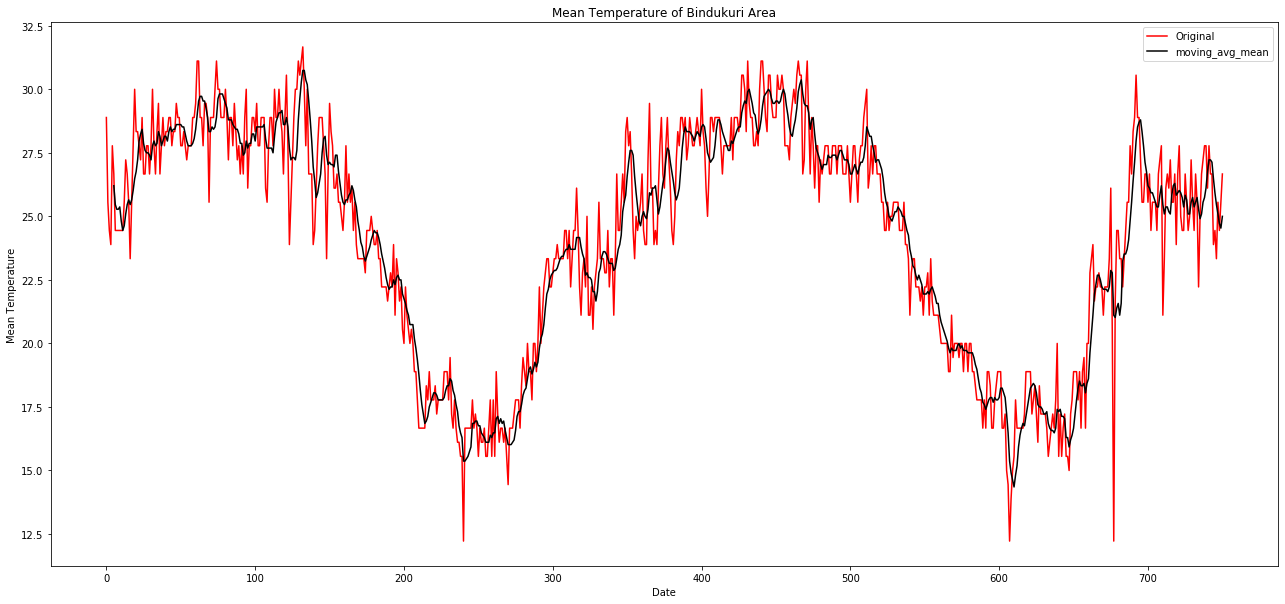

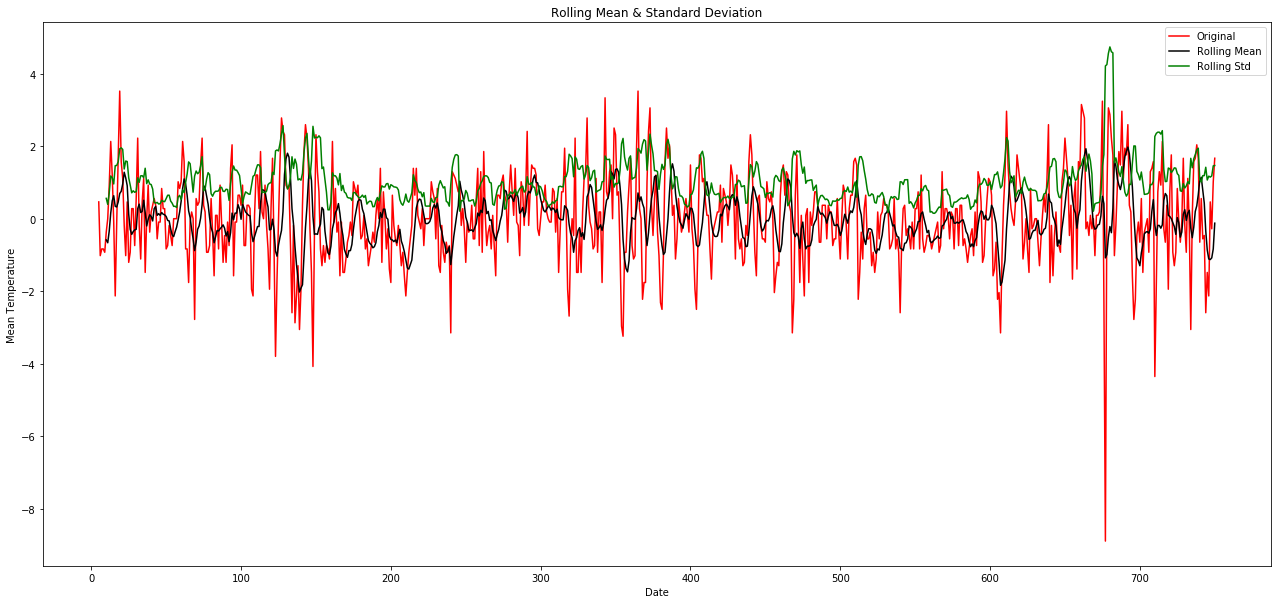

Test statistic:  -11.138514335138474
p-value:  3.150868563164652e-20
Critical Values: {'1%': -3.4392539652094154, '5%': -2.86546960465041, '10%': -2.5688625527782327}


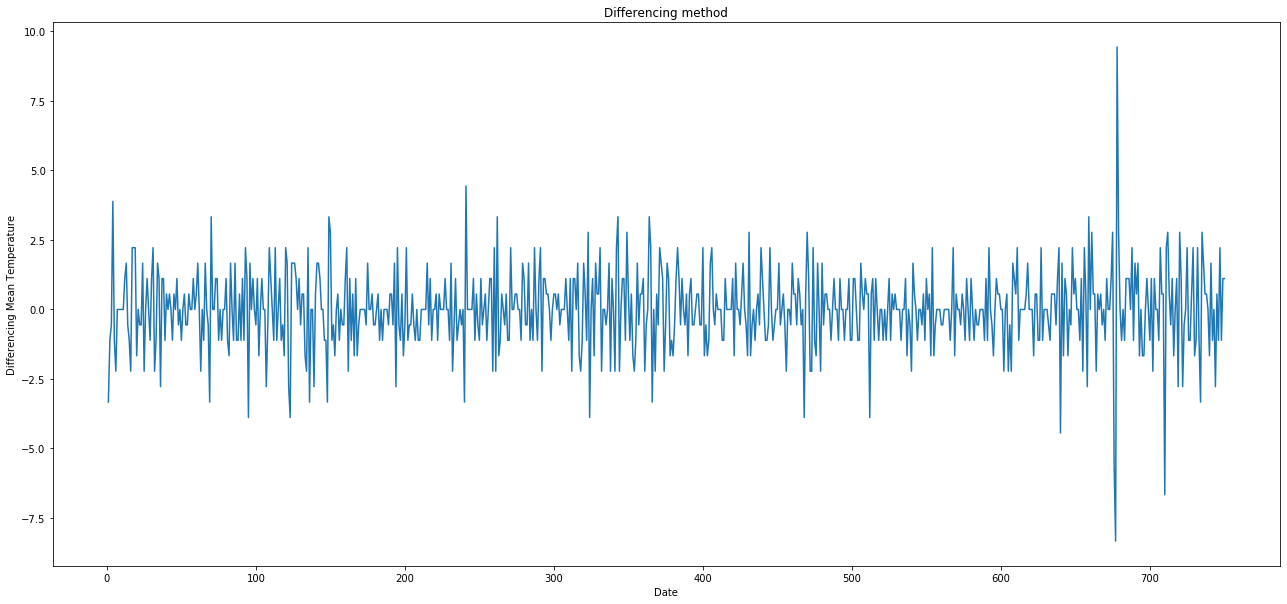

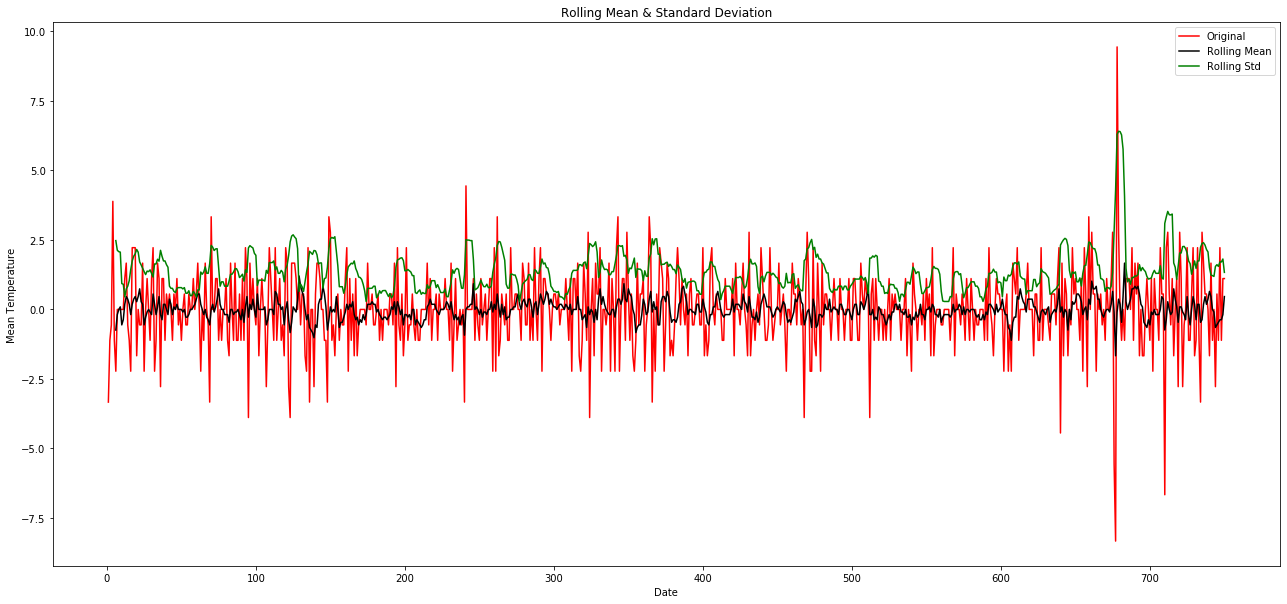

Test statistic:  -11.678955575105347
p-value:  1.7602075693561612e-21
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


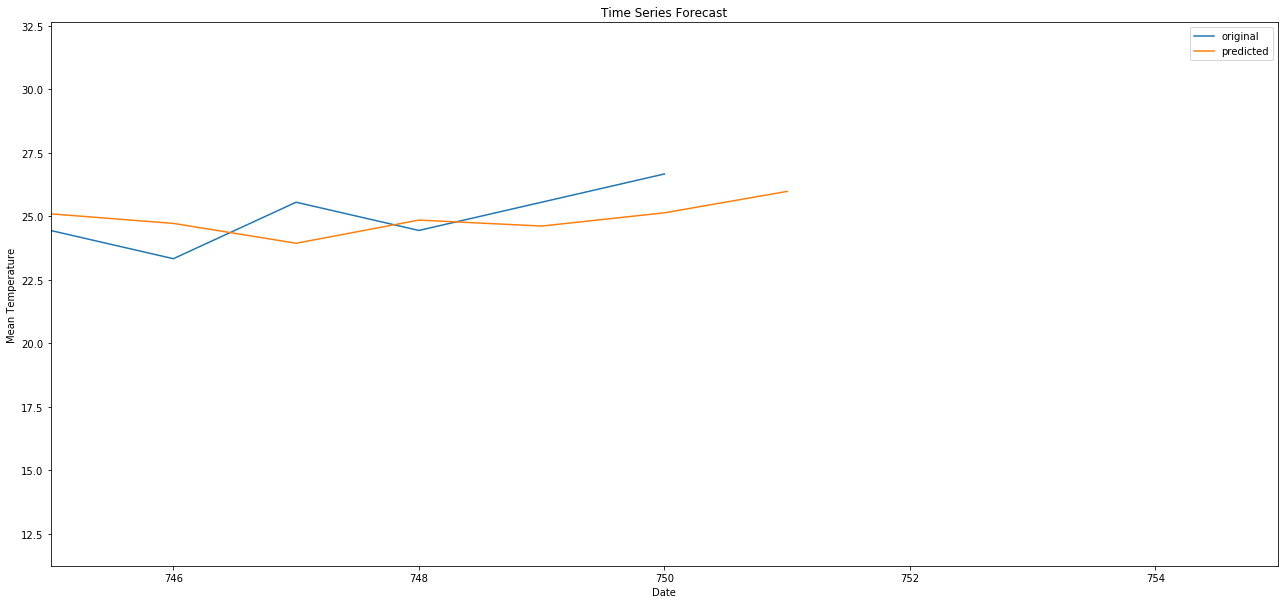

In [9]:
# adfuller library 
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(t3):
    # Dickey-Fuller test
    result = adfuller(t3, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

# check_mean_std
def check_mean_std(t3):
    #Rolling statistics
    #rolmean = pd.rolling_mean(ts, window=6)
    rolmean = t3.rolling(window=6).mean()
    #rolstd = pd.rolling_std(ts, window=6)
    rolstd = t3.rolling(window=6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(t3, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

# check stationary: mean, variance(std)and adfuller test
check_mean_std(t3)
check_adfuller(t3.MeanTemp)

# Moving average method
window_size = 6
#moving_avg = pd.rolling_mean(ts,window_size)
moving_avg = t3.rolling(window_size).mean()

plt.figure(figsize=(22,10))
plt.plot(t3, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

t3_moving_avg_diff = t3 - moving_avg
t3_moving_avg_diff.dropna(inplace=True) 
check_mean_std(t3_moving_avg_diff)
check_adfuller(t3_moving_avg_diff.MeanTemp)

# differencing method
t3_diff = t3 - t3.shift()
plt.figure(figsize=(22,10))
plt.plot(t3_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

t3_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(t3_diff)
check_adfuller(t3_diff.MeanTemp)

# ARIMA LİBRARY
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(t3, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit(disp=0)

# predict
start_index = (700)
end_index = (751)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.xlim(745, 755)
plt.plot(t3,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:               MeanTemp   No. Observations:                  750
Model:                        SARIMAX   Log Likelihood               -1331.318
Date:                Sat, 11 Apr 2020   AIC                           2664.636
Time:                        20:26:12   BIC                           2669.256
Sample:                             0   HQIC                          2666.416
                                - 750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.0387      0.058     34.886      0.000       1.924       2.153
Ljung-Box (Q):                       99.48   Jarque-Bera (JB):               632.38
Prob(Q):                              0.00   Pr

NameError: name 'SARIMA_0_0_0_000' is not defined

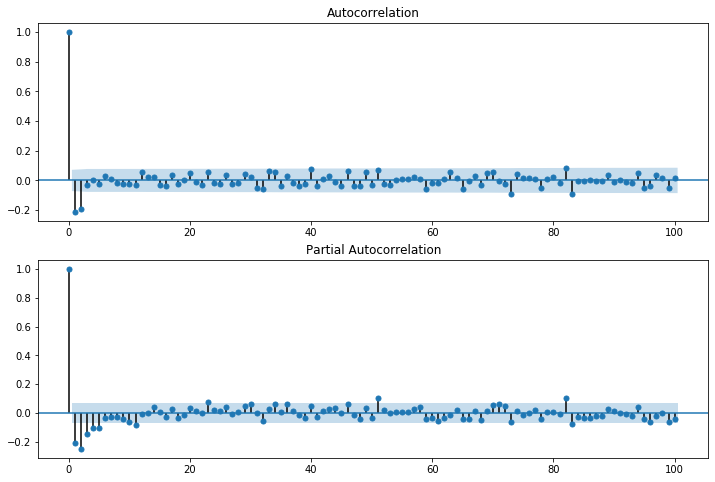

In [10]:
import statsmodels.api as sm
SARIMA_3_1_2_111 = sm.tsa.SARIMAX(t3_diff, order=(0,0,0), seasonal_order=(0,0,0,300)).fit()
print(SARIMA_3_1_2_111.summary())

residSARIMA = SARIMA_3_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=100, ax=ax2)

pred = SARIMA_0_0_0_000.predict(700, 1200)

plt.figure(figsize=(22,10))
plt.plot(t3)
plt.plot(pred, "r")

In [ ]:
import statsmodels.api as sm
SARIMA_1_1_1_010 = sm.tsa.SARIMAX(t3_diff, order=(1,1,1), seasonal_order=(0,1,0,300)).fit()
print(SARIMA_1_1_1_010.summary())

residSARIMA = SARIMA_1_1_1_010.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=100, ax=ax2)

pred = SARIMA_1_1_1_010.predict(700, 1200)

plt.figure(figsize=(22,10))
plt.plot(t3)
plt.plot(pred, "r")

In [ ]:
import statsmodels.api as sm
SARIMA_1_1_1_010 = sm.tsa.SARIMAX(t3_diff, order=(1,1,1), seasonal_order=(0,1,0,360)).fit()
print(SARIMA_1_1_1_010.summary())

residSARIMA = SARIMA_1_1_1_010.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=100, ax=ax2)

pred = SARIMA_1_1_1_010.predict(700, 1200)

plt.figure(figsize=(22,10))
plt.plot(t3)
plt.plot(pred, "r")

In [ ]:
import statsmodels.api as sm
SARIMA_1_0_1_010 = sm.tsa.SARIMAX(t3, order=(1,0,1), seasonal_order=(0,1,0,300)).fit()
print(SARIMA_1_0_1_010.summary())

residSARIMA = SARIMA_1_0_1_010.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=100, ax=ax2)


pred = SARIMA_1_0_1_010.predict(700, 1200)
plt.figure(figsize=(22,10))
plt.plot(t3)
plt.plot(pred, "r")

In [ ]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 1
max_sp = 0
max_sq = 0
max_sd = 0

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])


season = 360

# 自動SARIMA選択
#BICも観ておきたいので改造する
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            t3, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,360), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.ix[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.ix[num]["aic"] = sarima.aic
                        modelSelection.ix[num]["bic"] = sarima.bic

                        num = num + 1


#ここはaicを基準にしておこう
#aicが低い順からtop3を出して選べるようにしてもいいかも(ページ下側でやる)
modelSelection[modelSelection.aic == min(modelSelection.aic)]

In [ ]:
AIC=[]
BIC=[]
pr_li=[]

p_num = 4
d_num = 4
q_num = 4
trial_num = p_num * d_num * q_num
use_columns = ["p", "d", "q"]
step_cnt = 0
train_data = t3

info_df = pd.DataFrame(index=range(trial_num-2), columns=use_columns)

for p in range(p_num):
    for d in range(d_num):
        for q in range(q_num):
            if p == 0 and q == 0:
                continue
            model = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q), enforce_invertibility=False, trend='t')
            param_list = [p, d, q]
            for name, val in zip(use_columns[:-1], param_list):
                info_df.iloc[step_cnt][name] = val
            try:
                result = model.fit(disp=False)
                AIC.append(result.aic)
                BIC.append(result.bic)
                pr_li.append(param_list)
            except:
                pass
            step_cnt += 1
            print("Finish trial No. {}, Param: {}".format(step_cnt, param_list))

grid_ser = pd.DataFrame({"palam" : pr_li,
              "AIC" : AIC,
              "BIC" : BIC
             })

so=sorted(grid_ser.AIC)[:5]
grid_ser[grid_ser.AIC==so[0]]

#結果が1,1,2と出てきたので適応する

model112 =  sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 2), trend='c')
result112 = model112.fit(disp=False)
print(result112.summary())